In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F # all nn functions

## Initial setup

### Data

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=1786)

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50
type(n), type(x_train)

(int, torch.Tensor)

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)
pred[:30, :]

pred.shape, y_train.shape, y_train.min(), y_train.max() # y_train - 1 result for each input, 
#output of final hidden layer contains a node for each result and possible output value

(torch.Size([50000, 10]), torch.Size([50000]), tensor(0), tensor(9))

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [9]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()
# each softmax < 1, log < 1 gives -ve number, perfect prediction will go to 0

In [10]:
sm_pred = log_softmax(pred)
sm_pred[0,:], sm_pred.shape , sm_pred.min(), pred.min(), pred. max()

(tensor([-2.3307, -2.3505, -2.2193, -2.4758, -2.2904, -2.2250, -2.3392, -2.1800,
         -2.3221, -2.3242], grad_fn=<SliceBackward>),
 torch.Size([50000, 10]),
 tensor(-2.7475, grad_fn=<MinBackward1>),
 tensor(-0.4694, grad_fn=<MinBackward1>),
 tensor(0.3169, grad_fn=<MaxBackward1>))

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [11]:
y_train[:3], y_train.shape # get the trainig set

(tensor([5, 0, 4]), torch.Size([50000]))

In [12]:
sm_pred.shape,sm_pred[[0,1,2], [5,0,4]].mean(), sm_pred[[0, 1, 2]]

(torch.Size([50000, 10]),
 tensor(-2.2586, grad_fn=<MeanBackward0>),
 tensor([[-2.3307, -2.3505, -2.2193, -2.4758, -2.2904, -2.2250, -2.3392, -2.1800,
          -2.3221, -2.3242],
         [-2.3387, -2.4016, -2.1755, -2.4922, -2.2707, -2.2662, -2.2443, -2.2284,
          -2.2842, -2.3624],
         [-2.2067, -2.4184, -2.2629, -2.4175, -2.2120, -2.2198, -2.3614, -2.2327,
          -2.3657, -2.3627]], grad_fn=<IndexBackward>))

In [13]:
y_train.shape[0]

50000

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2081)

In [14]:
def nll(input, target): return -input[range(target.shape[0]), target].mean() # negative log likeihood
# input - this is the output of the last layer
# target - this is y_train - using indexing 

In [15]:
loss = nll(sm_pred, y_train) # put softmax result in here

In [16]:
loss

tensor(2.3126, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [17]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log() # simplify softmax

In [18]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [19]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log() # avoid overflow

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [20]:
test_near(logsumexp(pred), pred.logsumexp(-1))
logsumexp(pred), pred.logsumexp(-1)

(tensor([2.2646, 2.2751, 2.2912,  ..., 2.2707, 2.2909, 2.2689],
        grad_fn=<AddBackward0>),
 tensor([2.2646, 2.2751, 2.2912,  ..., 2.2707, 2.2909, 2.2689],
        grad_fn=<LogsumexpBackward>))

So we can use it for our `log_softmax` function.

In [21]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [22]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [23]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [24]:
test_near(F.cross_entropy(pred, y_train), loss) # nnl loss of softmax is cross entropy

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2542)

In [25]:
loss_func = F.cross_entropy

In [26]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [27]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape, x_train[0:bs].shape

(tensor([-0.0661, -0.0859,  0.0452, -0.2112, -0.0258,  0.0396, -0.0746,  0.0846,
         -0.0575, -0.0597], grad_fn=<SelectBackward>),
 torch.Size([64, 10]),
 torch.Size([64, 784]))

In [28]:
yb = y_train[0:bs]
x = loss_func(preds,yb)

loss_func(preds, yb), torch.argmax(preds, dim = 1), yb,


(tensor(2.3251, grad_fn=<NllLossBackward>),
 tensor([7, 2, 0, 2, 2, 7, 7, 7, 7, 7, 7, 2, 2, 4, 7, 7, 8, 5, 2, 7, 0, 2, 7, 2,
         2, 4, 7, 4, 6, 2, 2, 7, 2, 7, 2, 2, 0, 2, 2, 2, 7, 2, 2, 7, 2, 7, 5, 7,
         2, 7, 2, 5, 2, 2, 7, 7, 2, 7, 0, 7, 2, 2, 0, 5]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
         1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
         9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0]))

In [29]:
accuracy(preds, yb)

tensor(0.0156)

In [30]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for
range((n-1)//bs + 1), n-1, n//bs

(range(0, 782), 49999, 781)

In [31]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward() # I think backward performs chain rule, i.e. calulates the gradients from the loss function
        with torch.no_grad(): # don't worry about updating the gradients
            for l in model.layers: # loop through layers 
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr # update weights
                    l.bias   -= l.bias.grad   * lr # update bias
                    l.weight.grad.zero_() # zero the gradients
                    l.bias  .grad.zero_() # zero the gradients

In [32]:
loss_func(model(xb), yb), accuracy(model(xb), yb), yb, torch.argmax(model(xb), dim = 1)

model.layers[0].weight


Parameter containing:
tensor([[ 0.0250, -0.0252,  0.0090,  ...,  0.0188, -0.0212,  0.0057],
        [-0.0008,  0.0130,  0.0026,  ..., -0.0185,  0.0179, -0.0183],
        [ 0.0097,  0.0226,  0.0072,  ..., -0.0158,  0.0185,  0.0341],
        ...,
        [ 0.0240,  0.0208, -0.0208,  ..., -0.0253,  0.0314, -0.0280],
        [ 0.0195, -0.0152,  0.0119,  ..., -0.0175,  0.0213, -0.0180],
        [ 0.0087, -0.0305, -0.0054,  ...,  0.0140,  0.0125, -0.0159]],
       requires_grad=True)

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2818)

In [33]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [34]:
model = Model(m, nh, 10)

In [35]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [36]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [37]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [39]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2035, grad_fn=<NllLossBackward>), tensor(0.9375))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [40]:
class boom:
    pass

f = boom()
f.vv = 1
#g = boom()
#g.vv


class Frob:
    def __setattr__(self, name, value):
        self.__dict__[name] = value.upper()
        
ff = Frob()
ff.xx = "hello"
ff.xx, f.vv


('HELLO', 1)

In [41]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {} # empty dictinoary of modules
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v # don't want to start with _
        super().__setattr__(k,v) # do what the super class does
        
    def __repr__(self): return f'{self._modules}' # this prints the representation when the class name is called
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [42]:
mdl = DummyModule(m,nh,10)
mdl, mdl.parameters()

({'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)},
 <generator object DummyModule.parameters at 0x7fc6a8a82a98>)

In [43]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2997)

In [44]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [45]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [46]:
model = Model(layers)

In [47]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3173)

In [48]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [49]:
model = SequentialModel(layers)

In [50]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [51]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0710, grad_fn=<NllLossBackward>), tensor(1.))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3199)

In [52]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [53]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1165, grad_fn=<NllLossBackward>), tensor(0.9375))

In [54]:
nn.Sequential??

In [55]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3278)

In [56]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [57]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [58]:
opt = Optimizer(model.parameters())

In [59]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [60]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1059, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [61]:
#export
from torch import optim

In [62]:
optim.SGD.step??

In [63]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [64]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2835, grad_fn=<NllLossBackward>)

In [65]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [66]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.3329, grad_fn=<NllLossBackward>), tensor(0.9375))

Randomized tests can be very useful.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3442)

In [67]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3578)

In [68]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [69]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [70]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [71]:
model,opt = get_model()

In [72]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [73]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1251, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3674)

In [115]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [134]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, 100)
#len(valid_dl)
cnt = 0
for x, y in valid_dl:
    print(y)
    cnt += 1
    print(cnt)
cnt = 0
for x, y in valid_dl:
    print(y)
    cnt += 1
    print(1000+cnt)

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1,
        0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7,
        8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5,
        0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 9, 4, 4, 5, 6, 6, 1, 7,
        2, 8, 6, 9])
1
tensor([7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9, 1, 7, 6, 0,
        9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7, 9, 9, 6, 7,
        3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2, 6, 9, 8, 8,
        8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8, 0, 6, 1, 3,
        2, 0, 8, 6])
2
tensor([0, 3, 5, 4, 9, 0, 3, 1, 0, 9, 3, 2, 3, 3, 3, 7, 4, 9, 2, 1, 6, 2, 1, 5,
        7, 1, 9, 7, 9, 2, 2, 8, 1, 7, 7, 0, 0, 1, 8, 9, 0, 6, 6, 4, 7, 9, 8, 2,
        9, 1, 5, 2, 5, 3, 7, 7, 0, 0, 8, 2, 3, 1, 3, 5, 1, 3, 6, 4, 8, 7, 6, 2,
        8, 1, 8, 6, 6, 8, 7, 5, 6, 0, 4, 8, 4, 9, 3, 2, 3, 6, 2, 0, 1, 1, 

In [117]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

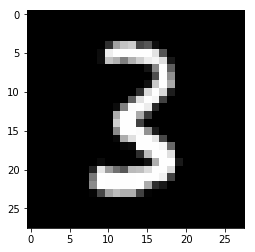

In [118]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [119]:
model,opt = get_model()

In [124]:
epochs = 5

def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        print("Training ac, epoch: " + str( epoch ) + " loss: " +str(loss))

In [125]:
fit()

Training ac, epoch: 0 loss: tensor(0.0324, grad_fn=<NllLossBackward>)
Training ac, epoch: 1 loss: tensor(0.0124, grad_fn=<NllLossBackward>)
Training ac, epoch: 2 loss: tensor(0.0129, grad_fn=<NllLossBackward>)
Training ac, epoch: 3 loss: tensor(0.0096, grad_fn=<NllLossBackward>)
Training ac, epoch: 4 loss: tensor(0.0051, grad_fn=<NllLossBackward>)


In [81]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1123, grad_fn=<NllLossBackward>), tensor(0.9844))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3942)

In [82]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [83]:
small_ds = Dataset(*train_ds[:10])

In [84]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [85]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([6, 4, 5]), tensor([1, 7, 3]), tensor([9, 2, 0]), tensor([8])]

In [111]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [87]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [113]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)
len(train_dl)

TypeError: object of type 'DataLoader' has no len()

(tensor(3), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

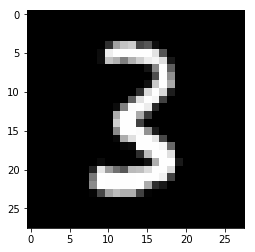

In [89]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0], xb

TypeError: object of type 'DataLoader' has no len()

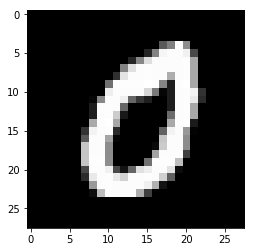

In [114]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0], len(train_dl)

tensor(7)

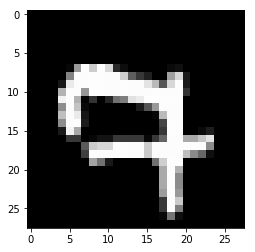

In [91]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [92]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1076, grad_fn=<NllLossBackward>), tensor(0.9531))

### PyTorch DataLoader

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=4171)

In [93]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [94]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [95]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1606, grad_fn=<NllLossBackward>), tensor(0.9531))

PyTorch's defaults work fine for most things however:

In [96]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [97]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1343, grad_fn=<NllLossBackward>), tensor(0.9531))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=4260)

In [103]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

In [104]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [105]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2970) tensor(0.9059)
1 tensor(0.1350) tensor(0.9583)
2 tensor(0.2083) tensor(0.9403)
3 tensor(0.1231) tensor(0.9629)
4 tensor(0.1275) tensor(0.9640)


In [107]:
assert acc>0.9
len(valid_dl)

79

## Export

In [ ]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to nb_03.py
